In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats



In [2]:
df = pd.read_csv('../datasets/tg_parsed_alarms.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   started       470 non-null    object 
 1   finished      470 non-null    object 
 2   duration_min  470 non-null    float64
 3   alarm_type    470 non-null    object 
dtypes: float64(1), object(3)
memory usage: 14.8+ KB
None


<Axes: xlabel='duration_min', ylabel='Count'>

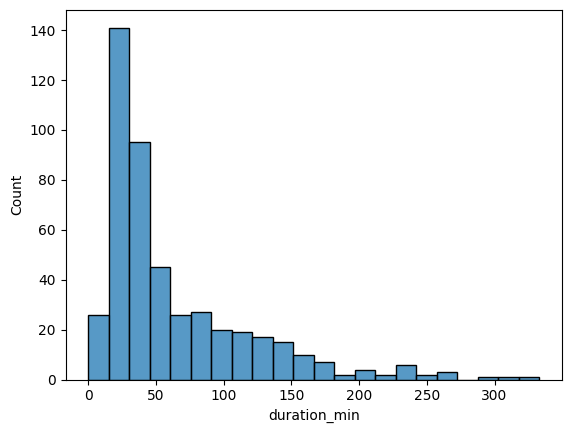

In [3]:
sns.histplot(df["duration_min"])

просто частота тривог з певною тривалістю, там можна шось про skewness написати

Exponential params (loc, scale): (0.0, 63.45865671641791)
Gamma params (shape, loc, scale): (1.6543260590946713, 0, np.float64(38.35921967592387))


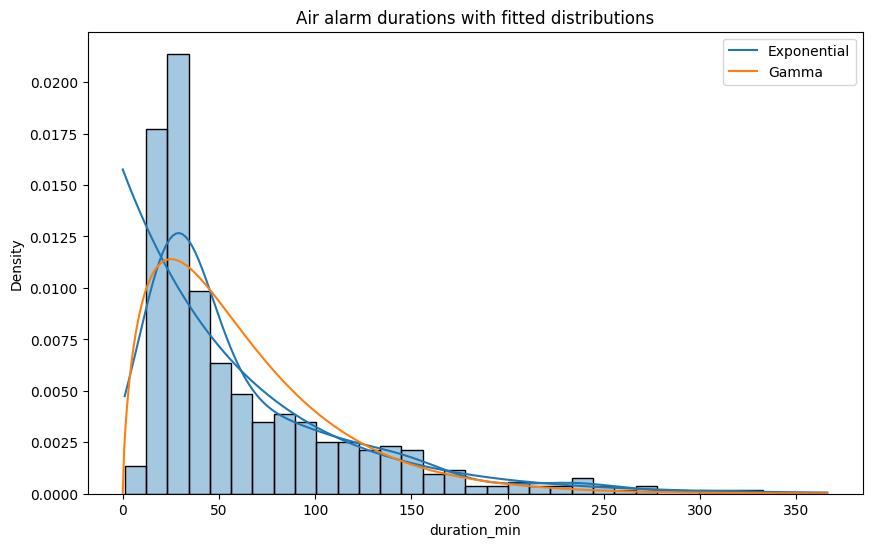

In [4]:
# 1. Prepare data
data = df["duration_min"].dropna().values  # air-raid duration in minutes
data = data[data > 0]                      # remove zeros if any

# 2. Histogram + KDE of the data
plt.figure(figsize=(10, 6))
sns.histplot(data, bins=30, stat="density", kde=True, alpha=0.4)
plt.xlabel("duration_min")
plt.ylabel("Density")
plt.title("Air alarm durations with fitted distributions")

# 3. Fit candidate distributions (MLE via scipy)

# Exponential (force support starting at 0)
exp_params = stats.expon.fit(data, floc=0)     # (loc=0, scale)
# Gamma
gamma_params = stats.gamma.fit(data, floc=0)   # (shape, loc=0, scale)

print("Exponential params (loc, scale):", exp_params)
print("Gamma params (shape, loc, scale):", gamma_params)

# 4. Overlay PDFs on the same plot
x = np.linspace(0, data.max() * 1.1, 500)

exp_pdf = stats.expon.pdf(x, *exp_params)
gamma_pdf = stats.gamma.pdf(x, *gamma_params)

plt.plot(x, exp_pdf, label="Exponential")
plt.plot(x, gamma_pdf, label="Gamma")

plt.legend()
plt.show()

чисто інтуїтивно екпоненційний підходить для наших даних бо він про тривалість, в гаммі теж про таке щось є тому треба дивитись як ми зможемо вивести параметри



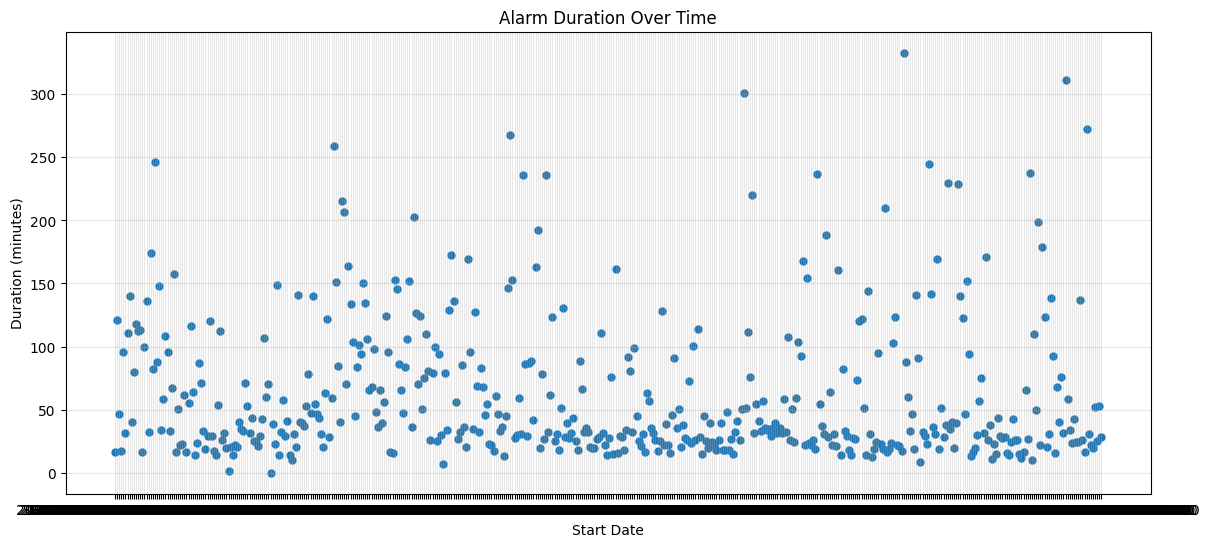

In [5]:
plt.figure(figsize=(14, 6))
plt.scatter(df["started"], df["duration_min"], s=25)

plt.title("Alarm Duration Over Time")
plt.xlabel("Start Date")
plt.ylabel("Duration (minutes)")
plt.grid(True, alpha=0.3)

plt.show()

це дата і тривалість, нічо нам не дає

In [6]:

df["started"] = pd.to_datetime(df["started"])
df["duration_min"] = pd.to_numeric(df["duration_min"], errors="coerce")
weekly_mean = (
    df.set_index("started")
      .resample("W")["duration_min"]
      .mean()
      .reset_index()
)

weekly_mean.head()

,started,duration_min
0,2023-04-02 00:00:00+00:00,16.480000
1,2023-04-09 00:00:00+00:00,120.800000
2,2023-04-16 00:00:00+00:00,46.900000
3,2023-04-23 00:00:00+00:00,48.263333
4,2023-04-30 00:00:00+00:00,111.020000


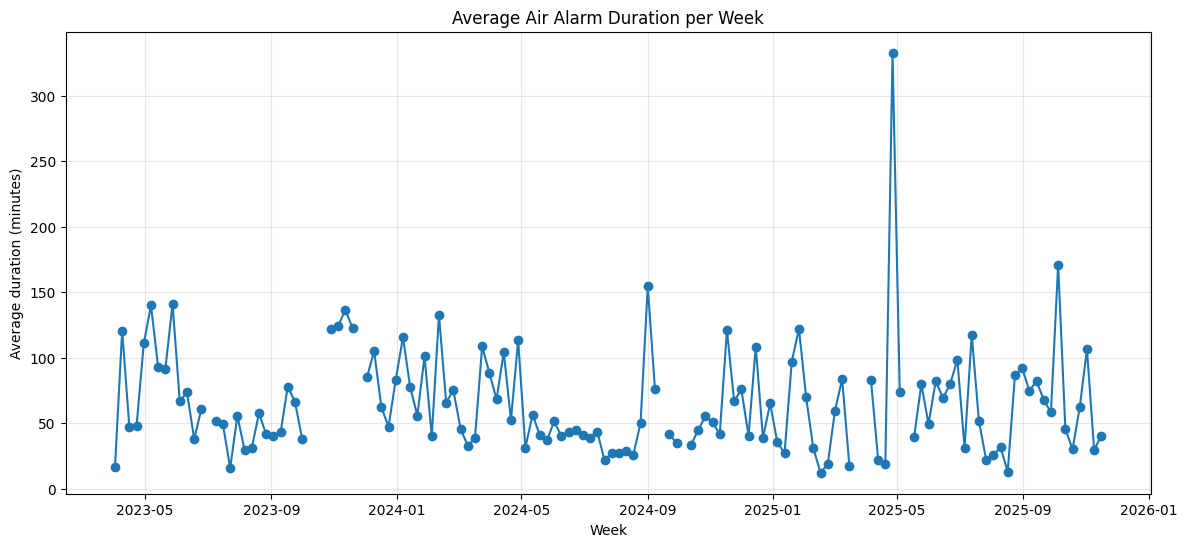

In [7]:
plt.figure(figsize=(14, 6))
plt.plot(weekly_mean["started"], weekly_mean["duration_min"], marker="o")

plt.title("Average Air Alarm Duration per Week")
plt.xlabel("Week")
plt.ylabel("Average duration (minutes)")
plt.grid(True, alpha=0.3)

plt.show()

це як минулий але вже середнє по тижнях, теж хуйня

In [8]:
monthly_mean = (
    df.set_index("started")
      .resample("M")["duration_min"]
      .mean()
      .reset_index()
)

/var/folders/_0/qmn1bzt50cq3b1rjz_1c25m00000gn/T/ipykernel_8862/3875973583.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["duration_min"]


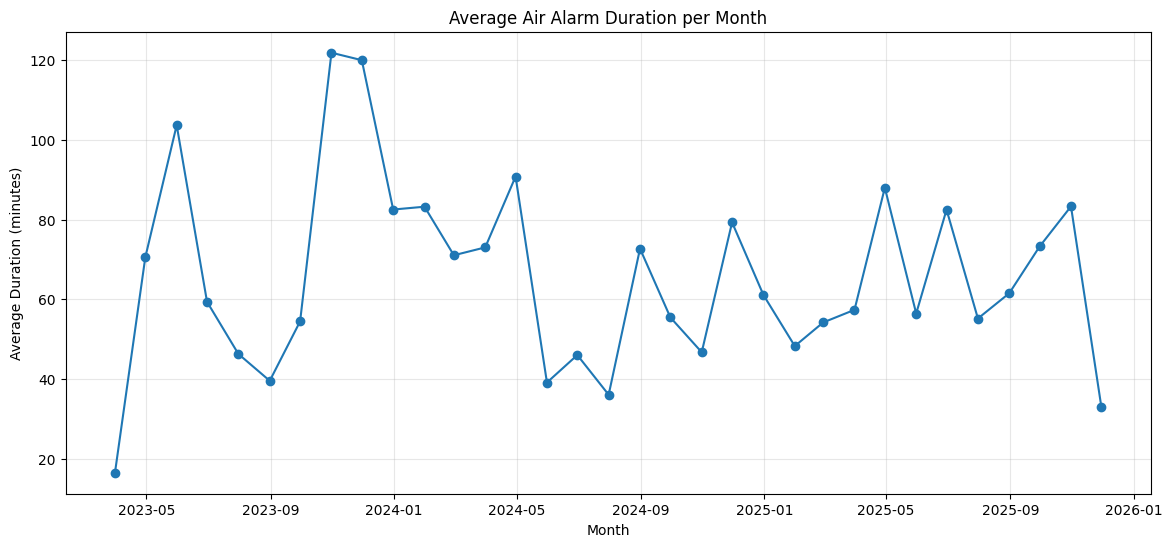

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(monthly_mean["started"], monthly_mean["duration_min"], marker="o")

plt.title("Average Air Alarm Duration per Month")
plt.xlabel("Month")
plt.ylabel("Average Duration (minutes)")
plt.grid(True, alpha=0.3)

plt.show()

те саме по місяцях, короче не буде тут залежності

In [10]:
df["weekday"] = df["started"].dt.dayofweek

In [11]:
weekday_mean = (
    df.groupby("weekday")["duration_min"]
      .mean()
      .reset_index()
      .sort_values("weekday")
)

In [12]:
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
weekday_mean["weekday_name"] = weekday_mean["weekday"].apply(lambda x: weekday_labels[x])

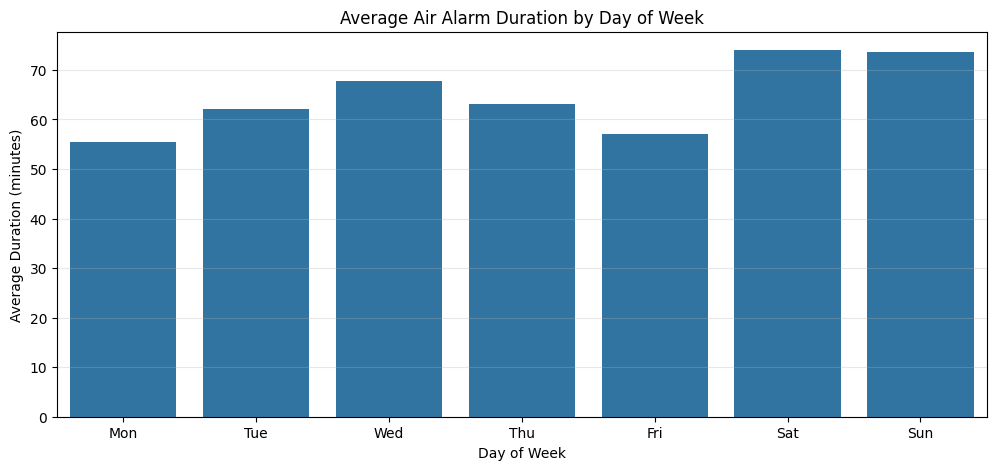

In [13]:
plt.figure(figsize=(12, 5))
sns.barplot(data=weekday_mean, x="weekday_name", y="duration_min")

plt.title("Average Air Alarm Duration by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Duration (minutes)")
plt.grid(True, axis="y", alpha=0.3)

plt.show()

це по днях тижня, на вихідних трохи довші але не думаю що це так сильно впливати буде

In [14]:
df["hour"] = df["started"].dt.hour
hourly = df.groupby("hour")["duration_min"].mean().reset_index()

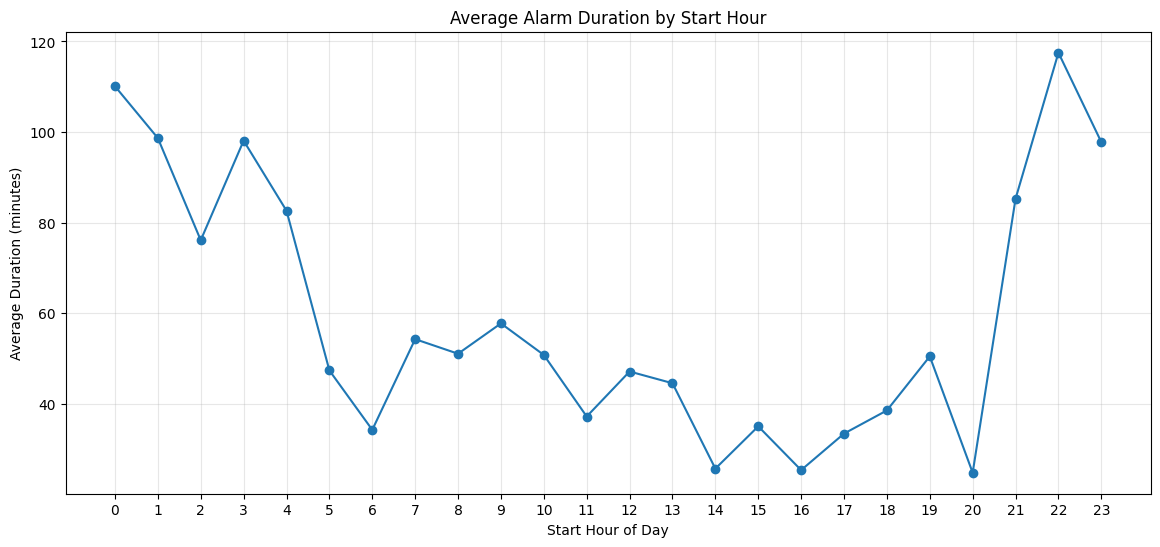

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(hourly["hour"], hourly["duration_min"], marker="o")

plt.title("Average Alarm Duration by Start Hour")
plt.xlabel("Start Hour of Day")
plt.ylabel("Average Duration (minutes)")
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)

plt.show()

тут середня тривалість від години початку, загалом залежність видно але треба думати як це як параметр вивести

In [16]:
alarm_avg = (
    df.groupby("alarm_type")["duration_min"]
      .mean()
      .reset_index()
      .sort_values("duration_min")
)

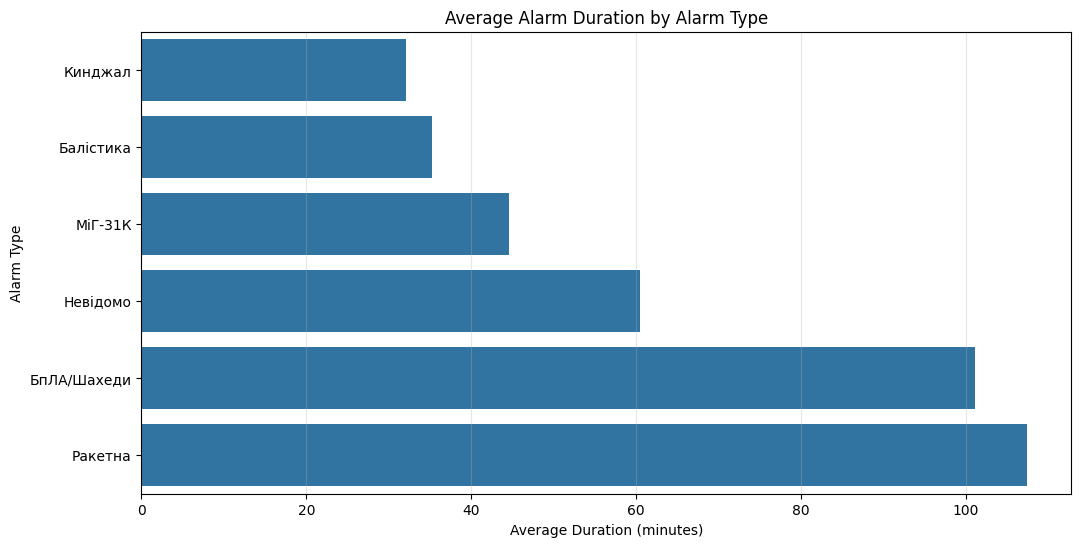

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(data=alarm_avg, x="duration_min", y="alarm_type")
plt.title("Average Alarm Duration by Alarm Type")
plt.xlabel("Average Duration (minutes)")
plt.ylabel("Alarm Type")
plt.grid(True, axis="x", alpha=0.3)
plt.show()